### Noisy Gates model vs Qiskit

Trial of the noisy gates model with the update at qiskit 1.0.2 version with the new bases gates which is used the ECR gate instead of the CNOT

In [1]:
# Standard libraries
import numpy as np 
import json
from datetime import datetime

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# Own library
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, AlternativeCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import fix_counts
from quantum_gates.quantum_algorithms import ghz_circ, qaoa_circ, qft_circ, hadamard_reverse_qft_circ




In [2]:
# provider
IBM_TOKEN = "token"
provider = IBMProvider(token=IBM_TOKEN)

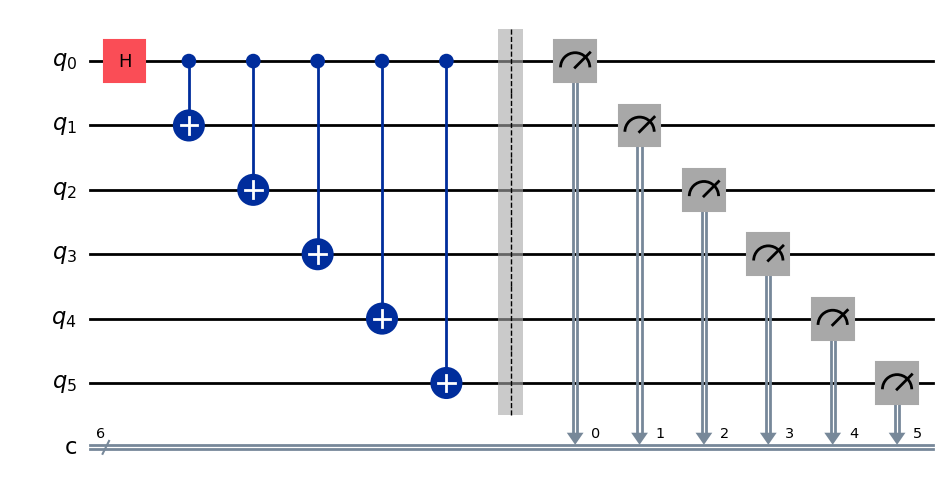

In [3]:
#The circuit
N_QUBIT = 6
N_BIT = N_QUBIT
depth = 1


#circ = random_circuit(N_QUBIT, depth, seed = 1, measure=True)

"""
circ = QuantumCircuit(N_QUBIT,N_BIT)
circ.h(0)
circ.cx(0,1)
circ.measure(range(N_QUBIT),range(N_BIT))
"""


#circ = hadamard_reverse_qft_circ(N_QUBIT)
#circ = qft_circ(N_QUBIT)
circ = ghz_circ(N_QUBIT)


circ.draw('mpl')


In [ ]:
#wavefunction simulation
#display(array_to_latex(Statevector.from_instruction(circ), prefix="\\text{Statevector} = "))

In [4]:
# Simulation quantities
qubits_layout = list(range(N_QUBIT)) 
psi0 = [1] + [0] * (2**N_QUBIT-1) # starting state
SHOTS = 1000 # number of shots

# Device parameters import
backend = provider.get_backend('ibm_brisbane')
prop = backend.properties()
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()

In [5]:
# transpilation of the circuit
t_circ = transpile(
    circ,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42
)

#t_circ.draw('mpl')

We only support a linear connectivity at the moment.
Our CPU count is 8
Use 80% of the cores, so 6 processes.
As we perform 1000 shots, we use a chunksize of 167.


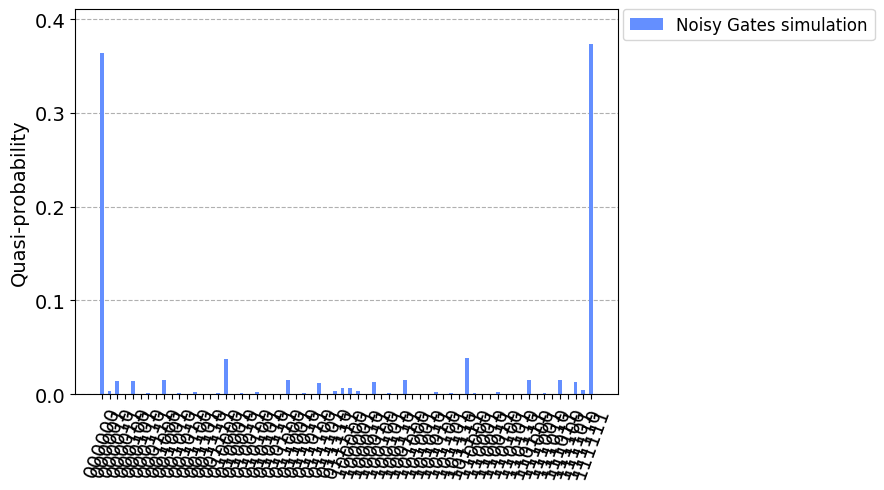

In [6]:
# simulation with the Noisy Gates

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= True)

probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(psi0), 
    shots=SHOTS, 
    device_param=device_param_lookup,
    nqubit=N_QUBIT)

counts_ng = {format(i, 'b').zfill(N_QUBIT): probs[i] for i in range(0, 2**N_QUBIT)}

plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

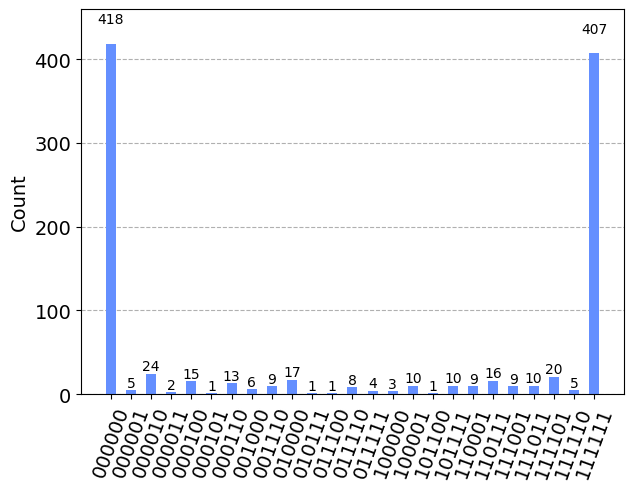

In [8]:
# Simulation with Qiskit


backend = FakeBrisbane()
# Run the transpiled circuit using the simulated backend
job = backend.run(t_circ)
counts_qiskit = job.result().get_counts()
plot_histogram(counts_qiskit)

In [9]:
# convert dict in list for the noisy gates output
counts_ng_list = [(key, value) for key, value in counts_ng.items()]
counts_ng_list_sort = sorted(counts_ng_list, key=lambda x: x[1], reverse = True)

# convert in standard qubit convention the qiskit simulation output
counts_qiskit_list = fix_counts(counts_qiskit, N_QUBIT) # convert qiskit output in standard notation
counts_qiskit_list_sort = sorted(counts_qiskit_list, key=lambda x: x[1], reverse = True)

# unify the list as a np.array
counts_ng_array = np.array(counts_ng_list)
counts_qiskit_array = np.array(counts_qiskit_list)

counts_merge = np.concatenate((counts_ng_array, counts_qiskit_array[:,1].reshape(-1, 1)), axis=1)



In [10]:
counts_merge

array([['000000', '0.36429334345261166', '418'],
       ['000001', '0.00309855197308738', '3'],
       ['000010', '0.013640755485821571', '17'],
       ['000011', '0.0003172084600830993', '0'],
       ['000100', '0.013884688151981597', '6'],
       ['000101', '0.00012731847317517912', '0'],
       ['000110', '0.0006525910928188845', '0'],
       ['000111', '0.000282032229666649', '0'],
       ['001000', '0.015151293161724538', '15'],
       ['001001', '0.0001430649062183109', '0'],
       ['001010', '0.0005876455133856799', '0'],
       ['001011', '4.0225603764161945e-05', '0'],
       ['001100', '0.0016324460094155663', '0'],
       ['001101', '3.7949545749182884e-05', '1'],
       ['001110', '0.0003661584630331592', '1'],
       ['001111', '0.0006652107599228584', '0'],
       ['010000', '0.03693369447641832', '24'],
       ['010001', '0.0003000454297825778', '0'],
       ['010010', '0.0013556412048414761', '0'],
       ['010011', '3.936975742152894e-05', '0'],
       ['010100', '0.0